In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from get_data import *
from dataloader import *
from test_function import *
from NN_classes import *
import logging
import os

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

torch.Size([50, 2750, 3])
input_data size torch.Size([50, 2750, 3])


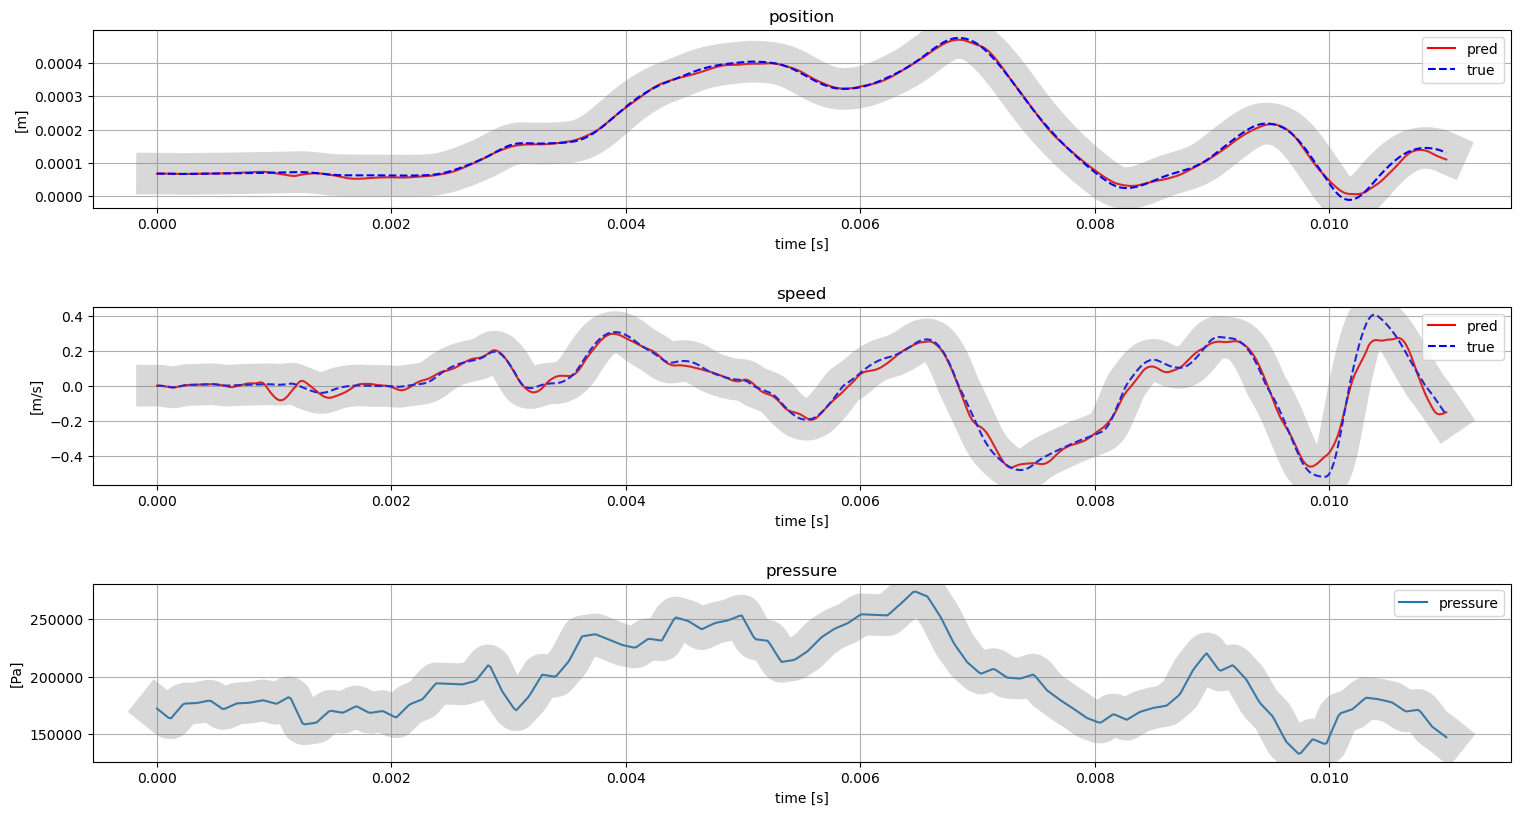

Error first half:  0.0
Error second half:  0.0
total loss full traj:  0.0001112088904221691


In [16]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = r"Ventil_trained_NNs\OR_TCN2.pth"

params =                          {
                            "experiment_number" : 4,
                            "window_size" : 30,
                            "epochs" : 50,
                            "learning_rate" : 0.001,
                            "part_of_data" : 50, 
                            "percentage_of_data" : 0.7,
                            "batch_size" : 20,
                            "future" : 1,
                            "drop_half_timesteps" : True,
                            "cut_off_timesteps" : 0,

                            "input_channels" : 3,
                            "output" : 2,
                            "n_hidden" : 5,
                            "levels" : 4,
                            "kernel_size" : 7,
                            "dropout" : 0

                        }



input_data1, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test_5xlonger_dyndyn.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "data\save_data_test_5xlonger_dyndyn.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                        

#input_data = torch.cat((input_data1, input_data3))
#input_data=input_data1[:,:,0:550-params["cut_off_timesteps"]]
input_data=input_data3

print(input_data.size())

np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

# Initialize the LSTM model

input_channels = params["input_channels"]
output = params["output"]
num_channels = [params["n_hidden"]] * params["levels"]
kernel_size = params["kernel_size"]
dropout = params["dropout"]

model = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params["window_size"])

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
#%matplotlib qt 
#%matplotlib inline 

#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(input_data1.to(device), model, model_type = "or_tcn", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
#print(total_loss)
#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]

In [15]:

# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchcde
import time


def plot_results(x, pred, pred_next_step=None, physics_rescaling=None, additional_data=None):

    if x.dim() == 3:
        x = x.view(x.size(dim=1), x.size(dim=2))
    if pred.dim() == 3:
        pred = pred.view(pred.size(dim=1), pred.size(dim=2))
    if pred_next_step != None:
        if pred_next_step.dim() == 3:
            pred_next_step = pred_next_step.view(pred_next_step.size(dim=1), pred_next_step.size(dim=2))

        #scale back:    
    if physics_rescaling != None:

        # we invert:
        # x = (x - xmin)/(xmax - xmin)
        # x * (xmax - xmin) + xmin

        pred[:,0] = pred[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
       # pred[:,0] = pred[:,0]/1e5
        pred[:,1] = pred[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        pred[:,2] = pred[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
        x[:,0] = x[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
       # x[:,0] = x[:,0]/1e5
        x[:,1] = x[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        x[:,2] = x[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

        if additional_data != None:
            for i in range(additional_data.size(dim=0)):
                additional_data[i,:,0] = additional_data[i,:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
                additional_data[i,:,1] = additional_data[i,:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
                additional_data[i,:,2] = additional_data[i,:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    #figure , axs = plt.subplots(1,3,figsize=(20,8))
    figure , axs = plt.subplots(3,1, figsize=(16,9))
    figure.tight_layout(pad=5.0)

    greek_letterz=[chr(code) for code in range(945,970)]
    mu = greek_letterz[11]

    stepsize = 2e-5
    time = np.linspace(0,x.size(dim=0)* stepsize, x.size(dim=0))

    if pred_next_step != None:
        axs[0].plot(time, pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
        axs[1].plot(time, pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")

    axs[0].plot(time, pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
    axs[0].plot(time, x.detach().cpu().numpy()[:, 1], color="grey", linewidth = 30, alpha = 0.3)
    axs[0].plot(time, x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
    if additional_data != None:
        for i in range(additional_data.size(dim=0)):
           names = ["simulink", "Hub im Regler"]
           axs[0].plot(time, additional_data[i, :, 1], label=names[i])

    axs[0].set_title("position")
    axs[0].set_ylabel("[m]")
    axs[0].set_xlabel(f"time [s]")
    axs[0].grid()
    axs[0].legend()


    axs[1].plot(time, pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
    axs[1].plot(time, x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
    axs[1].plot(time, x.detach().cpu().numpy()[:, 2], color="grey", linewidth = 30, alpha = 0.3)
    if additional_data != None:
        for i in range(additional_data.size(dim=0)):
           names = ["simulink", "Hub im Regler"]
           axs[1].plot(time, additional_data[i, :, 2], label=names[i])
    axs[1].set_title("speed")
    axs[1].set_ylabel("[m/s]")
    axs[1].set_xlabel(f"time [s]")
    axs[1].grid()
    axs[1].legend()

    axs[2].plot(time, x.detach().cpu().numpy()[:,0], label="pressure")
    axs[2].plot(time, x.detach().cpu().numpy()[:, 0], color="grey", linewidth = 30, alpha = 0.3)
    if additional_data != None:
       for i in range(additional_data.size(dim=0)):
           names = ["simulink", "Hub im Regler"]
           axs[2].plot(time, additional_data[i, :, 0], label=names[i])
    axs[2].set_title("pressure")
    axs[2].set_ylabel("[Pa]")
    axs[2].set_xlabel(f"time [s]")
    axs[2].grid()
    axs[2].legend()


   


    plt.grid(True)
    plt.legend()
    plt.show()



def test(data, model, model_type = "or_lstm", window_size=10, display_plots=False, num_of_inits = 5, set_rand_seed=True, physics_rescaling = 0, additional_data=None):

    if model_type not in ["or_lstm", "lstm", "mlp", "gru", "tcn", "or_tcn", "neural_cde", "or_mlp"]:
        print("Error: model_type = ", model_type, "available options are: [or_lstm, lstm, mlp, gru, tcm]")
        return 0

    
    device = "cpu" if data.get_device() == -1 else "cuda:0"
    
    if data.dim() != 3:
        print("data tensor has unexpected dimension", data.dim(), "expected", 3 )
        return 0
    
    timesteps = data.size(dim=1)

    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0
    total_firsthalf = 0
    total_secondhalf = 0
   
    if set_rand_seed:
     np.random.seed(1234)

    test_inits = data.size(dim=0)
    ids = np.random.choice(test_inits, min([num_of_inits, test_inits]), replace=False)
    ids = np.unique(ids)
    

    if model_type in ["or_lstm", "gru"]:
        for i, x in enumerate(data):

            x=x.to(device)        
            x = x.view(1,x.size(dim=0), x.size(dim=1))

            if i not in ids:
                continue
    
            with torch.inference_mode():
    
                pred = torch.zeros((timesteps, 3), device=device)
    
                if window_size > 1:
                    pred[0:window_size, :] = x[0, 0:window_size, :]
                    pred[:, 0] = x[0, :, 0]
    
                else:
                    pred[0, :] = x[0, 0, :]
                    pred[:, 0] = x[0, :, 0]
    

                out, _ = model(x)
                pred[window_size:,1:] = out

                print(x.size(), pred.size())
                test_loss += loss_fn(pred[window_size:, 1], x[0, window_size:, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[window_size:, 2], x[0, window_size:, 2]).detach().cpu().numpy()
                total_loss += loss_fn(pred[window_size:, 1:], x[0, window_size:, 1:]).detach().cpu().numpy()

                total_firsthalf += loss_fn(pred[window_size:int((timesteps-window_size)/2), 1:], 
                        x[0, window_size:int((timesteps-window_size)/2), 1:]).detach().cpu().numpy()  
                total_secondhalf += loss_fn(pred[int((timesteps-window_size)/2):, 1:],
                            x[0, int((timesteps-window_size)/2):, 1:]).detach().cpu().numpy()

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling, additional_data=additional_data)

    if model_type == "mlp":
        for i, x in enumerate(data):

                x=x.to(device)
                
                if i not in ids:
                    continue
        
                with torch.inference_mode():
        
                    pred = torch.zeros((timesteps, 3), device=device)
        
                    if window_size > 1:
                        pred[0:window_size, :] = x[0:window_size, :]
                        pred[:, 0] = x[ :, 0]
        
                    else:
                        pred[0, :] = x[0, :]
                        pred[:, 0] = x[:, 0]

                    inp = torch.cat((x[:window_size,0], x[:window_size,1], x[:window_size,2]))

                    for t in range(1,timesteps - window_size + 1 ): 

                        out = model(inp)
                        pred[window_size+(t-1):window_size+t,1:] =  pred[window_size+(t-2):window_size+(t-1):,1:] + out
                        new_p = pred[t:t+window_size,0]
                        new_s = pred[t:t+window_size,1]
                        new_v = pred[t:t+window_size,2]
                        
                        inp = torch.cat((new_p, new_s, new_v))

                    test_loss += loss_fn(pred[window_size:, 1], x[window_size:, 1]).detach().cpu().numpy()
                    test_loss_deriv += loss_fn(pred[window_size:, 2], x[window_size:, 2]).detach().cpu().numpy()
                    total_loss += loss_fn(pred[window_size:, 1:], x[window_size:, 1:]).detach().cpu().numpy()

                    
                    total_firsthalf += loss_fn(pred[window_size:int((pred.size(dim=0)-window_size)/2), 1:], 
                                            x[window_size:int((pred.size(dim=0)-window_size)/2), 1:]).detach().cpu().numpy()  
                    total_secondhalf += loss_fn(pred[int((pred.size(dim=0)-window_size)/2):, 1:],
                                                x[int((pred.size(dim=0)-window_size)/2):, 1:]).detach().cpu().numpy()  
                    #print("Error first half: ", total_firsthalf)
                    #print("Error second half: ", total_secondhalf)

                    if display_plots:
                        plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling, additional_data=additional_data)

    if model_type == "lstm":
        for i, x in enumerate(data):
            x=x.to(device)
            if i not in ids:
                continue

            with torch.inference_mode():

                pred = torch.zeros((timesteps, 3), device=device)
                pred_next_step = torch.zeros((timesteps, 3), device=device)

                if window_size > 1:
                    pred[0:window_size, :] = x[0:window_size, :]
                    pred[:, 0] = x[:, 0]
                    pred_next_step[0:window_size, :] = x[0:window_size, :]
                    pred_next_step[:, 0] = x[:, 0]
                else:
                    pred[0, :] = x[0, :]
                    pred[:, 0] = x[:, 0]
                    pred_next_step[0, :] = x[0, :]
                    pred_next_step[:, 0] = x[:, 0]

                for i in range(len(x) - window_size):

                    out, _ = model(pred[i:i+window_size, :])
                    pred[i+window_size, 1:] = pred[i+window_size-1, 1:] + out[-1, :]
                    pred_next_step[i+window_size, 1:] = x[i+window_size-1, 1:] + out[-1, :]
                
                test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

                total_loss += loss_fn(pred[:, 1:], x[:, 1:]).detach().cpu().numpy()

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling , additional_data=additional_data)

    if model_type == "tcn" :
         for i, x in enumerate(data):
            
            if i not in ids:
                continue

            with torch.inference_mode():

                x=x.to(device)        
                x = x.view(1,x.size(dim=0), x.size(dim=1))

                pred = torch.zeros_like(x, device=device)  
                pred_next_step = torch.zeros_like(x, device=device)               

                pred[:, 0:window_size, :] = x[0, 0:window_size, :]
                pred[:, :, 0] = x[0, :, 0]

                for i in range(1,x.size(1) - window_size + 1):

                    pred[:, window_size+(i-1):window_size+i,1:] =  pred[:, window_size+(i-2):window_size+(i-1):,1:] + model(pred[:,i:window_size+(i-1),:].transpose(1,2))    

                test_loss += loss_fn(pred[0, :, 1], x[0, :, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[0, :, 2], x[0, :, 2]).detach().cpu().numpy()

                total_loss += loss_fn(pred[0, :, 1:], x[0, :, 1:]).detach().cpu().numpy()

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling , additional_data=additional_data)

    if model_type == "or_tcn" :
         for i, x in enumerate(data):
            
            if i not in ids:
                continue

            with torch.inference_mode():
                x=x.to(device)        
                x = x.view(1,x.size(dim=0), x.size(dim=1))                
                pred = torch.zeros((timesteps, 3), device=device)
    
                if window_size > 1:
                    pred[0:window_size, :] = x[0, 0:window_size, :]
                    pred[:, 0] = x[0, :, 0]
    
                else:
                    pred[0, :] = x[0, 0, :]
                    pred[:, 0] = x[0, :, 0]
    
                x_test = x.clone()
                x_test[:,window_size:,1:] = 0
                x_test = x_test.to(device)
                #print("Data passed to the model, all 0 after the initial window to prove that the forward pass is correct and doesnt access information it shouldnt.",x_test[:,0:10,:])

                out = model(x_test.transpose(1,2))
                
                pred[window_size:,1:] = out.squeeze(0).transpose(0,1)

                test_loss += loss_fn(pred[window_size:, 1], x[0, window_size:, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[window_size:, 2], x[0, window_size:, 2]).detach().cpu().numpy()
                total_loss += loss_fn(pred[window_size:, 1:], x[0, window_size:, 1:]).detach().cpu().numpy()

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling , additional_data=additional_data)

    if model_type == "neural_cde" :
         for i, x in enumerate(data):
            
            if i not in ids:
                continue

            with torch.inference_mode():

                x=x.to(device)        
                x = x.view(1,x.size(dim=0), x.size(dim=1))

                pred = torch.zeros_like(x, device=device)
        
                pred[:, 0:window_size, :] = x[0:1, 0:window_size, :]
                pred[:, :, 0:2] = x[0:1, :, 0:2] # time, pressure

                #start_total=time.time()

                for i in range(x.size(1) - window_size):
                    
                    #start_coeffs=time.time()
                    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(pred[0:1, i:i+window_size, :]) 
                    #train_coeffs = torchcde.linear_interpolation_coeffs(pred[0:1, i:i+window_size, :])
   
                    #stop_coeffs=time.time()
                    #print(stop_coeffs-start_coeffs, "time: coeff calc one step")
                    if (i+1)%100==0:
                     print(i, " timessteps done")
                    #start=time.time()

                    out = model(train_coeffs)
                    pred[0:1, i+window_size, 2:] = pred[0:1, i+window_size-1, 2:] + out.unsqueeze(1)

                    #pred[0:1, i+window_size, 2:] = out
                    #stop=time.time()
                    #print(stop-start, "time: model calc step")

                test_loss += loss_fn(pred[0, window_size:, 2], x[0, window_size:, 2]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[0, window_size:, 3], x[0, window_size:, 3]).detach().cpu().numpy()
                total_loss += loss_fn(pred[0, window_size:, 2:], x[0, window_size:, 2:]).detach().cpu().numpy()

                total_firsthalf += loss_fn(pred[0, window_size:int((pred.size(dim=1)-window_size)/2), 2:], 
                                           x[0, window_size:int((pred.size(dim=1)-window_size)/2), 2:]).detach().cpu().numpy()  
                total_secondhalf += loss_fn(pred[0, int((pred.size(dim=1)-window_size)/2):, 2:],
                                             x[0, int((pred.size(dim=1)-window_size)/2):, 2:]).detach().cpu().numpy()  
                #print("Error first half: ", total_firsthalf)
                #print("Error second half: ", total_secondhalf)

                #stop_total=time.time()
               # print(stop_total-start_total, "time: model calc step")

                if display_plots:
                    plot_results(x[:,:,1:], pred[:,:,1:], pred_next_step=None, physics_rescaling=physics_rescaling , additional_data=additional_data)

    if model_type == "or_mlp" :
         for i, x in enumerate(data):
            
            if i not in ids:
                continue

            with torch.inference_mode():
                x=x.to(device)        
                x = x.view(1,x.size(dim=0), x.size(dim=1))                
                pred = torch.zeros((timesteps, 3), device=device)
    
                if window_size > 1:
                    pred[0:window_size, :] = x[0, 0:window_size, :]
                    pred[:, 0] = x[0, :, 0]
    
                else:
                    pred[0, :] = x[0, 0, :]
                    pred[:, 0] = x[0, :, 0]
    
                x_test = x.clone()
                x_test[:,window_size:,1:] = 0
                x_test = x_test.to(device)
                #print("Data passed to the model, all 0 after the initial window to prove that the forward pass is correct and doesnt access information it shouldnt.",x_test[:,0:10,:])

                out = model(x_test)
                
                pred[window_size:,1:] = out

                test_loss += loss_fn(pred[window_size:, 1], x[0, window_size:, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[window_size:, 2], x[0, window_size:, 2]).detach().cpu().numpy()
                total_loss += loss_fn(pred[window_size:, 1:], x[0, window_size:, 1:]).detach().cpu().numpy()

                total_firsthalf += loss_fn(pred[window_size:int((pred.size(dim=0)-window_size)/2), 1:], 
                                            x[0, window_size:int((pred.size(dim=0)-window_size)/2), 1:]).detach().cpu().numpy()  
                total_secondhalf += loss_fn(pred[int((pred.size(dim=0)-window_size)/2):, 1:],
                                                x[0, int((pred.size(dim=0)-window_size)/2):, 1:]).detach().cpu().numpy()  

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling , additional_data=additional_data)


    print("Error first half: ", np.mean(total_firsthalf))
    print("Error second half: ", np.mean(total_secondhalf))
    print("total loss full traj: ", np.mean(total_loss))

    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)

In [ ]:
input_data_new = input_data[0:3,0:15:,:].clone()
input_data_new[0:1,:,0:1] = 1
input_data_new[0:1,:,1:2] = 2
input_data_new[0:1,:,2:] = 3
input_data_new[1:2,:,0:1] = 4
input_data_new[1:2,:,1:2] = 5
input_data_new[1:2,:,2:] = 6
input_data_new[2:,:,0:1] = 7
input_data_new[2:,:,1:2] = 8
input_data_new[2:,:,2:] = 9

model(input_data_new.transpose(1,2))